# Space launches

This script fetches data from the [JSR Launch Vehicle Database](http://www.planet4589.org/space/lvdb/index.html) and arranges and formats them for creating the space launches graphic

In [2]:
library('tidyverse')
library('data.table')

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [3]:
readLauncherFile = function(url) {
    read.fwf(url,
         widths=c(15,11,21,25,7,21,25,25,25,10,9,17,7,2,5,2,13,13,5,25,25,21,21),
         strip.white=TRUE,
         col.names=c(
            'tag',
            'JD',
            'launch_date',
            'type',
            'variant',
            'flightID',
            'flight',
            'mission',
            'flightcode',
            'platform',
            'launchsite',
            'launchpad',
            'apogee',
            'apoflag',
            'range',
            'rangeflag',
            'dest',
            'agency',
            'launch_code',
            'group',
            'category',
            'LTCite',
            'cite'
            ),
         na.strings='-'
        ) %>% as.data.table
}

### Orbital launches

The JSR database is organized in several ways, but for our purposes, we are interested in launches that reached orbit, or tried to and failed. These are separated into three files. The `G` and `O` files are successful orbital launches (the "G" launches predate the standard cataloging system for launches but are otherwise the same thing). The `F` file includes orbital launch attempts that failed to make orbit.

In [4]:
orbitals = rbind(readLauncherFile('http://www.planet4589.org/space/lvdb/lis/G.lis')[,category:='O'],
                 readLauncherFile('http://www.planet4589.org/space/lvdb/lis/O.lis')[,category:='O'],
                 readLauncherFile('http://www.planet4589.org/space/lvdb/lis/F.lis')[,category:='F']
                ) %>%
    .[,launch_date := as.Date(substr(launch_date, 1, 16), format='%Y %b %d %H%M')] %>%
    .[,launch_year := substr(tag, 1, 4) %>% as.integer] %>%
    .[agency != 'UNK']
head(orbitals)

tag,JD,launch_date,type,variant,flightID,flight,mission,flightcode,platform,⋯,range,rangeflag,dest,agency,launch_code,group,category,LTCite,cite,launch_year
1957 ALP,2436116,1957-10-04,Sputnik 8K71PS,NA,M1-PS,PS-1,PS-1,NA,NA,⋯,NA,NA,NA,MVS,OS,NA,O,Energiya,SFLT39-331,1957
1957 BET,2436146,1957-11-03,Sputnik 8K71PS,NA,M1-2PS,PS-2,PS-2,NA,NA,⋯,NA,NA,NA,MVS,OS,NA,O,Grahn-WWW,Energiya,1957
1958 ALP,2436236,1958-02-01,Jupiter C,JunoI,RS-29 UE,Explorer 1,Explorer 1,NA,NA,⋯,NA,NA,NA,ABMA,OS,NA,O,JunoFam,NA,1958
1958 BET,2436280,1958-03-17,Vanguard,NA,TV-4,Vanguard I,Vanguard Test Satellite,NA,NA,⋯,NA,NA,NA,USN,OS,NA,O,SP-4202,Vang-ER9960,1958
1958 GAM,2436289,1958-03-26,Jupiter C,JunoI,RS-24 UT,Explorer 3,Explorer 3,NA,NA,⋯,NA,NA,NA,ABMA,OS,NA,O,JunoFam,NA,1958
1958 DEL,2436339,1958-05-15,Sputnik 8A91,NA,B1-1,ISZ D-1 No. 2,D-1 No. 2,NA,NA,⋯,NA,NA,NA,MVS,OS,NA,O,NezavB,Energiya,1958


The organizations file contains keys for all the organizations which are referenced in the database. We only care about a subset of these (the launch providers).

In [5]:
orgs = read.fwf('http://www.planet4589.org/space/lvdb/sdb/Orgs',
               widths=c(9,9,7,17,2,13,13,18,81,53,13,11,8,13,17,61,100),
               strip.white=TRUE,
               col.names=c(
                   'code',
                   'ucode',
                   'state_code',
                   'type',
                   'class',
                   'tstart',
                   'tstop',
                   'short_name',
                   'name',
                   'location',
                   'longitude',
                   'latitude',
                   'error',
                   'parent',
                   'short_english_name',
                   'english_name',
                   'unicode_name'
               ),
                skip=59,
               na.strings='-') %>% as.data.table
head(orgs)

code,ucode,state_code,type,class,tstart,tstop,short_name,name,location,longitude,latitude,error,parent,short_english_name,english_name,unicode_name
EARTH,EARTH,EARTH,AP,,NA,NA,Earth,Earth,Earth,,NA,NA,NA,Earth (Terra),Earth,Earth
LUNA,LUNA,LUNA,AP,,NA,NA,Luna,Luna,Luna,,NA,NA,NA,Moon,Moon,Luna
AAT,AAT,AAT,CY,,1841,NA,Aus. Antarctic,Australian Antarctic Territory,"Davis Staton, Princess Elizabeth Land",,NA,NA,AU,AAT,Australian Antarctic Territory,Australian Antarctic Territory
AF,AF,AF,CY,,2004,NA,Afghanistan,Da Afganistan Islami Jomhoriyat,Afghanistan,,NA,NA,NA,Afganistan,"Afghanistan, Islamic Republic of",د افغانستان اسلامي جمهوریت
AG,AG,AG,CY,,1981,NA,Antigua,Antigua and Barbuda,Antigua,,NA,NA,NA,Antigua,Antigua and Barbuda,Antigua and Barbuda
AGUK,AG,AGUK,CY,,1832,1981,Antigua,Antigua colony,Antigua,,NA,NA,UK,Antigua,Antigua and Barbuda,Antigua colony


If we've loaded everything correctly, we can merge these databases and get a rough view of the data.

Warning message:
“position_stack requires non-overlapping x intervals”

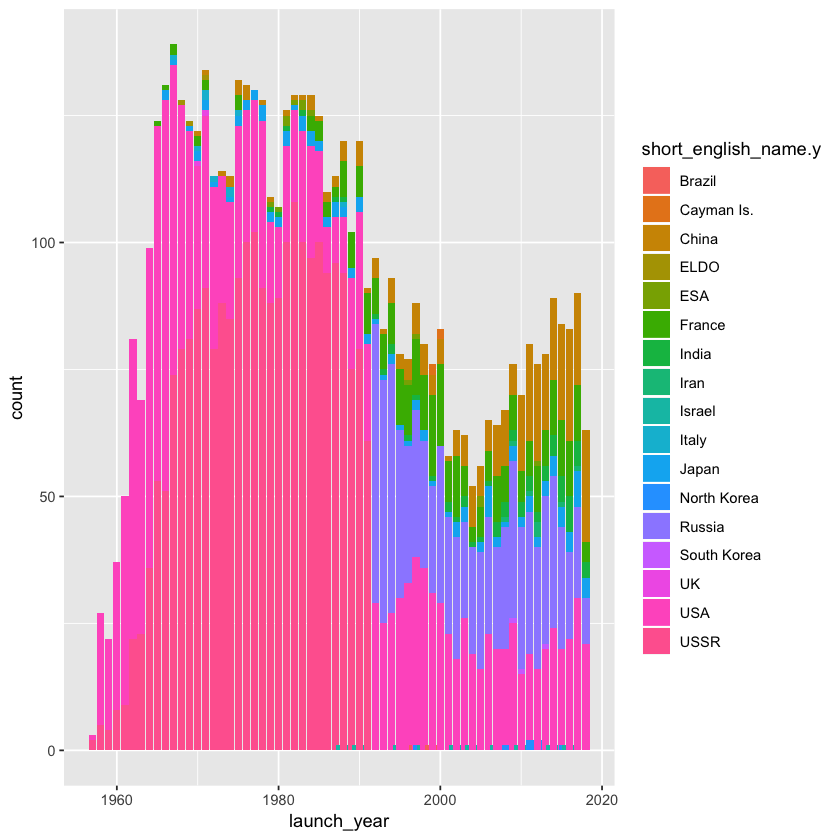

In [9]:
country_launches = merge(orbitals, orgs[,.(code,state_code,short_name, name, short_english_name)], by.x='agency', by.y='code')

country_launches %>%
    merge(orgs[,.(code,short_name,short_english_name)], by.x='state_code', by.y='code') %>%
    ggplot(aes(x=launch_year, fill=short_english_name.y)) +
    geom_bar()

As we said above, we only care about a subset of the agencies—those that actually launch orbital rockets. That is these ones:

In [10]:
country_launches[, .(count=.N), by=agency] %>%
    merge(orgs, by.x='agency', by.y='code') %>% .[order(-count)]

agency,count,ucode,state_code,type,class,tstart,tstop,short_name,name,location,longitude,latitude,error,parent,short_english_name,english_name,unicode_name
RVSN,1529,RVSN,SU,O/LA,D,1960,1991 Dec,RVSN,Rakentiye Voiska Strategicheskogo Naznacheniye,Mosvka?,,NA,NA,NA,NA,Strategic Rocket Forces,Ракетные войска стратегического назначения
UNKS,904,GUKOS,SU,O/LA,D,1986 Apr 24,1991,UNKS,Upravleniye Nachalnika Kosmicheskikh Sredstv,Moskva,,NA,NA,MO,NA,NA,Управление начальника космических средств МО СССР
NASA,469,NASA,US,O/LA/LV/PL/S,C,1958 Oct 1,NA,NASA,National Aeronautics and Space Administration,"Washington, D.C.",,NA,NA,NA,NA,NA,National Aeronautics and Space Administration
USAF,388,USAF,US,O/LA/S,D,1947 Sep 18,NA,USAF,United States Air Force,"Washington, DC:Pentagon",,NA,NA,NA,NA,NA,United States Air Force
AE,258,AE,F,O/LA,B,1980 Mar 26,2017 Mar,Arianespace,"Arianespace, Inc.","Paris:Evry, France",,NA,NA,NA,Arianespace,NA,"Arianespace, Inc."
AFSC,247,AFSC,US,LA,D,1961 Apr 1,1992 Jul 1,AFSC,"US Air Force Systems Command, Los Angeles AFS","El Segundo, California",,NA,NA,USAF,NA,NA,"US Air Force Systems Command, Los Angeles AFS"
VKSR,200,GUKOS,RU,O/LA,D,1997 Jul,2001 Jun 1,VKS RVSN,"Voenno-Kosmicheskiye Sili (Military Space Forces), RVSN","Mosvka:Solnechnogorsk, Rossiya",,NA,NA,RVSN,NA,Russian Military Space Forces,Военно-космические силы РВСН
CALT,181,CALT,CN,LA/LV/PL/E,C,1957 Nov 11,NA,CALT,Zhongguo yunzaihuojian jishu yanjiu yuan,Beijing:Nanyuan,,NA,NA,CASC,CALT,Chinese Academy of Launch Vehicle Technology (CASC 1st Acad),中国运载火箭技术研究院
FKA,128,MOM,RU,O/LA,C,2004,2016 Jan 1,Roskosmos,Federal'noe kosmicheskoe agentstvo Rossii (Roskosmos),Moskva,,NA,NA,NA,NA,Roskosmos,Федеральное космическое агентство (Роскосмос)
SAST,105,SBA,CN,O/LA/LV/PL,B,1993,NA,SAST,Shanghai hangtian jishu yanjiuyuan,Shanghai:Minghan,,NA,NA,CASC,NA,Shanghai Academy of Space Technology (CASC 8th Acad),上海航天技术研究院


These data are a little bit messy, and also contain no data about whether these are state or private launch operators. We've manually added these classifications in the `agencies.csv` file.

In [11]:
agencies = fread('./agencies.csv', na.strings = '-')
head(agencies)

agency,count,ucode,state_code,type,class,tstart,tstop,short_name,name,location,longitude,latitude,error,parent,short_english_name,english_name,unicode_name,agency_type
RVSN,1528,RVSN,SU,O/LA,D,1960,1991 Dec,RVSN,Rakentiye Voiska Strategicheskogo Naznacheniye,Mosvka?,NA,NA,NA,NA,NA,Strategic Rocket Forces,Ракетные войска стратегического назначения,state
UNKS,904,GUKOS,SU,O/LA,D,1986 Apr 24,1991,UNKS,Upravleniye Nachalnika Kosmicheskikh Sredstv,Moskva,NA,NA,NA,MO,NA,NA,Управление начальника космических средств МО СССР,state
NASA,469,NASA,US,O/LA/LV/PL/S,C,1958 Oct 1,NA,NASA,National Aeronautics and Space Administration,"Washington, D.C.",NA,NA,NA,NA,NA,NA,National Aeronautics and Space Administration,state
USAF,388,USAF,US,O/LA/S,D,1947 Sep 18,NA,USAF,United States Air Force,"Washington, DC-Pentagon",NA,NA,NA,NA,NA,NA,United States Air Force,state
AE,258,AE,F,O/LA,B,1980 Mar 26,*,Arianespace,"Arianespace, Inc.","Paris-Evry, France",NA,NA,NA,NA,Arianespace,NA,"Arianespace, Inc.",private
AFSC,247,AFSC,US,LA,D,1961 Apr 1,1992 Jul 1,AFSC,"US Air Force Systems Command, Los Angeles AFS","El Segundo, California",NA,NA,NA,USAF,NA,NA,"US Air Force Systems Command, Los Angeles AFS",state


The list also contains a lot of detail we aren't concerned with: for example, as far as we are concerned, NASA launches and US Air Force launches are both US government launches. Now that we know which are state entities, we can just swap in the "state code" and tidy our dataset up considerably.

In [23]:
country_agency_launches = merge(orbitals, agencies, by='agency') %>% 
    .[agency_type=='state',agency:=state_code]
head(country_agency_launches)

agency,tag,JD,launch_date,type.x,variant,flightID,flight,mission,flightcode,⋯,name,location,longitude,latitude,error,parent,short_english_name,english_name,unicode_name,agency_type
US,1967-065,2439671,1967-06-29,Thor Burner 2,NA,171/BII-3,P67-1,Secor Type II S/N 10,DEER FOOT,⋯,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.","Vandenberg AFB, California",NA,NA,NA,AFADC,NA,NA,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.",state
US,1967-080,2439726,1967-08-23,Thor Burner 2,NA,266/BII-4,DAPP 3419,DAPP 3419,NA,⋯,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.","Vandenberg AFB, California",NA,NA,NA,AFADC,NA,NA,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.",state
US,1967-096,2439775,1967-10-11,Thor Burner 2,NA,268/BII-5,DAPP 4417,DAPP 4417,NA,⋯,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.","Vandenberg AFB, California",NA,NA,NA,AFADC,NA,NA,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.",state
US,1968-042,2440000,1968-05-23,Thor Burner 2,NA,277/BII-6,DAPP 5420,DAPP 5420,NA,⋯,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.","Vandenberg AFB, California",NA,NA,NA,AFADC,NA,NA,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.",state
US,1968-092,2440153,1968-10-23,Thor Burner 2,NA,173/BII-8,DAPP 6422,DAPP 6422,NA,⋯,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.","Vandenberg AFB, California",NA,NA,NA,AFADC,NA,NA,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.",state
US,1969-062,2440426,1969-07-23,Thor Burner 2,NA,279/BII-7,DAPP 7421,DAPP 7421,NA,⋯,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.","Vandenberg AFB, California",NA,NA,NA,AFADC,NA,NA,"USAF Aerospace Defence Command, 10th Aerospace Defence Sqn.",state


We can simplify that a little more, and clean up our sorting

In [27]:
country_agency_launches_simplified = country_agency_launches[,.SD] %>%
    .[agency %in% agencies[parent=='USAF']$agency %>% unique, agency:='USAF'] %>%
    .[agency %in% agencies[parent=='USA']$agency %>% unique, agency:='USA'] %>%
    .[agency %in% agencies[parent=='CASC']$agency %>% unique, agency:='CASC'] %>%
    .[agency %in% agencies[parent=='CASIC']$agency %>% unique, agency:='CASIC']

manual_agency_levels = c('IN','CN','J','US','RU',
                         'SPX','ULAL','ULAB','ILSK','AE',
                         'MDSSC','OSC','BLS','LMA','MHI','ILSL','SEALP','STSM',
                         'EUROK','GDCLS','I-ESA','F','IL','I','IR','MMCLS','ELUS','KP',
                         'MMA','PU','SEALC','I-ELDO','KR','RSC','BR','OATK','UK','RLABU',
                         'EER','LMSC')
country_agency_launches_simplified$agency = factor(country_agency_launches_simplified$agency,
                                                  levels=manual_agency_levels)

And now we can make a (very very rough) version of our plot:

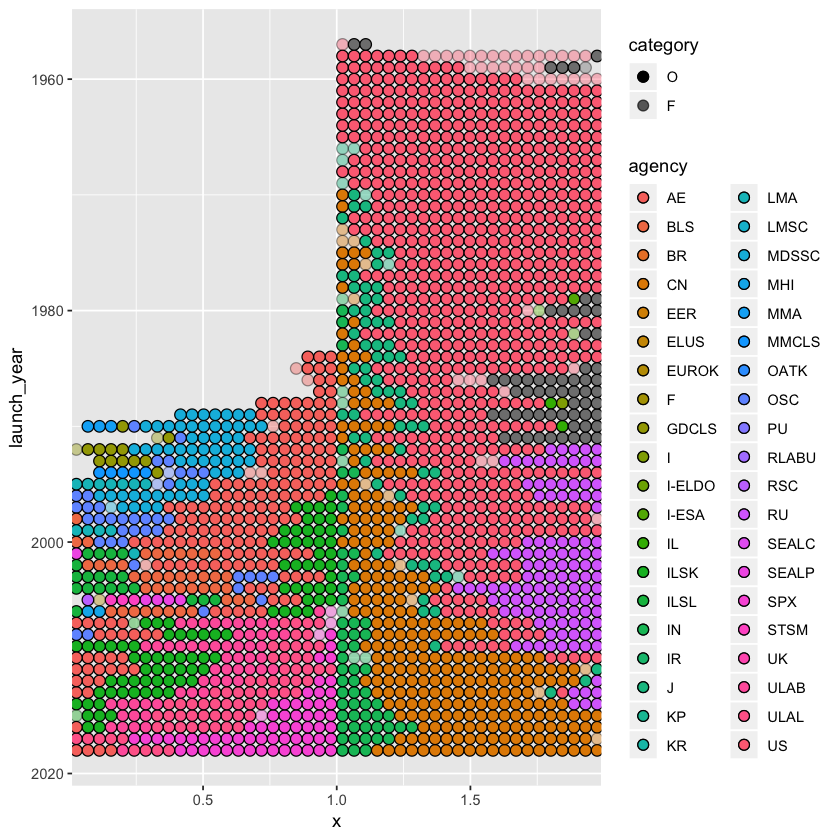

In [30]:
country_agency_launches_simplified %>% ggplot(aes(x=1, y=launch_year, fill=agency, alpha=category)) +
    scale_discrete_manual('alpha', values=c('O'=1,'F'=0.4)) +
    ylim(2018,1957) +
    geom_dotplot(data=country_agency_launches_simplified[agency_type=='state'],
                 binwidth=1, binaxis='y', stackdir='up', stackgroups=TRUE, binpositions='all') +
    geom_dotplot(data=country_agency_launches_simplified[agency_type!='state'],
                 binwidth=1, binaxis='y', stackdir='down', stackgroups=TRUE, binpositions='all')

The final chart was generated using D3 and finished in Illustrator, to allow somewhat more detailed positioning than ggplot allows, but it's quite similar in principle to the dotplot above, and uses the same dataset.